In [1]:
# основные библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# для кластеризации K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#для иерархической кластеризации 
from scipy.special.distance import pdist
from scipy.cluster.hierarchy import*

# для 3D визуализации
import plotly as py
import plotly.graph_objs as go

# для корректного отображения графиков
%matplotlib online 


ModuleNotFoundError: No module named 'scipy.special.distance'

In [ ]:
# загружаем файл с нашими данными и показываем первые пять строк для проверки
df = pd.read_csv('clustering_test_work.csv')
df.head()

In [12]:
#получаем информацию о каждом столбце
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247574 entries, 0 to 2247573
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   actual_id            int64  
 2   period_end           object 
 3   num                  int64  
 4   revenue_lastyear     float64
 5   quantity_lastyear    int64  
 6   orders_lastyear      int64  
 7   orders_refund        int64  
 8   ratio_not_dh         float64
 9   ratio_online         float64
 10  ratio_refund         float64
 11  avg_ratio_purchase   float64
 12  quantity_1st_period  float64
 13  unigenders           int64  
 14  recency              int64  
 15  aov                  float64
dtypes: float64(7), int64(8), object(1)
memory usage: 274.4+ MB


In [5]:
#проверяем основные статистические данные по всем параметрам (столбцам)
#по параметру count видим что пустых ячеек нет и нет надобности их заполнять
df = pd.read_csv('clustering_test_work.csv')
df.describe()

,Unnamed: 0,actual_id,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov
count,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06,2.247574e+06
mean,1.123786e+06,2.743856e+13,6.089290e+00,3.099290e+04,3.321365e+00,2.006601e+00,1.232200e-01,7.761333e-01,2.389008e-01,3.704832e-02,9.649268e-01,2.289252e+00,1.038383e+00,2.396081e+02,1.187220e+04
std,6.488189e+05,9.871432e+15,3.164263e+00,6.037296e+04,6.016230e+00,3.069162e+00,6.905141e-01,4.014436e-01,3.838896e-01,1.554406e-01,1.458924e-01,2.412920e+00,1.921185e-01,1.791003e+02,1.202568e+04
min,0.000000e+00,6.380000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,5.618932e+05,7.912462e+10,3.000000e+00,3.980000e+03,1.000000e+00,1.000000e+00,0.000000e+00,8.341633e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.140000e+02,3.480000e+03
50%,1.123786e+06,7.919928e+10,6.000000e+00,1.398000e+04,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.840000e+02,9.980000e+03
75%,1.685680e+06,7.950406e+10,8.000000e+00,3.492000e+04,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,3.630000e+02,1.624150e+04
max,2.247573e+06,4.415340e+18,1.400000e+01,7.365842e+06,6.290000e+02,2.810000e+02,1.260000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.380000e+02,2.000000e+00,8.270000e+02,4.307900e+05


# Выбор нужных столбцов для кластеризации

In [6]:
#выводим список всех столбцов
df.columns

Index(['Unnamed: 0', 'actual_id', 'period_end', 'num', 'revenue_lastyear',
       'quantity_lastyear', 'orders_lastyear', 'orders_refund', 'ratio_not_dh',
       'ratio_online', 'ratio_refund', 'avg_ratio_purchase',
       'quantity_1st_period', 'unigenders', 'recency', 'aov'],
      dtype='object')

Из списка всех имеющихся столбцов проверяем какие больше подходят для кластеризации
Для проверки я выбрал следующие столбцы по следующим причинам:

Recency: Количество дней от даты последнего выкупленного заказа до даты окончания i-ого периода. Эти значения могут помочь определить заинтересованность клиента в бренде и вероятность того что клиент сделает покупку в ближайшем будущем.

Quantity_lastyear: Количество выкупленных единиц товаров за 1 год от даты окончания i-ого периода. Эти значения могут определить доверие клиента к брэнду и его потенциальное значение для компании.

AOV (Average Order Value): Средний чек по выкупленным заказам за 1 год от даты окончания i-ого периода. Эти значения могут помочь определить покупательскую способность клиента и его потенциальное значение для компании.

Ratio_online: Доля заказов, оформленных онлайн, от общего числа оформленных заказов за 1 год от даты окончания i-ого периода. Эти значения могут помочь определить каким способом клиент предпочитает делать покупки.

Ratio_refund: Доля заказов, по которым был возврат, от общего числа выкупленных заказов за 1 год от даты окончания i-ого периода. Эти значения могут помочь определить насколько клиент удовлетворен брэндом и качеством продукта.

Unigenders: Количество уникальных гендерных характеристик принадлежности товарных позиций по оформленным заказам за все время жизни пользователя от даты окончания i-ого периода. Эти значения могут помочь определить предпочтения клиента.

Для проверки насколько взаимосвязаны данные параметры между собой используем матрицу рассеяний и гистограммы.


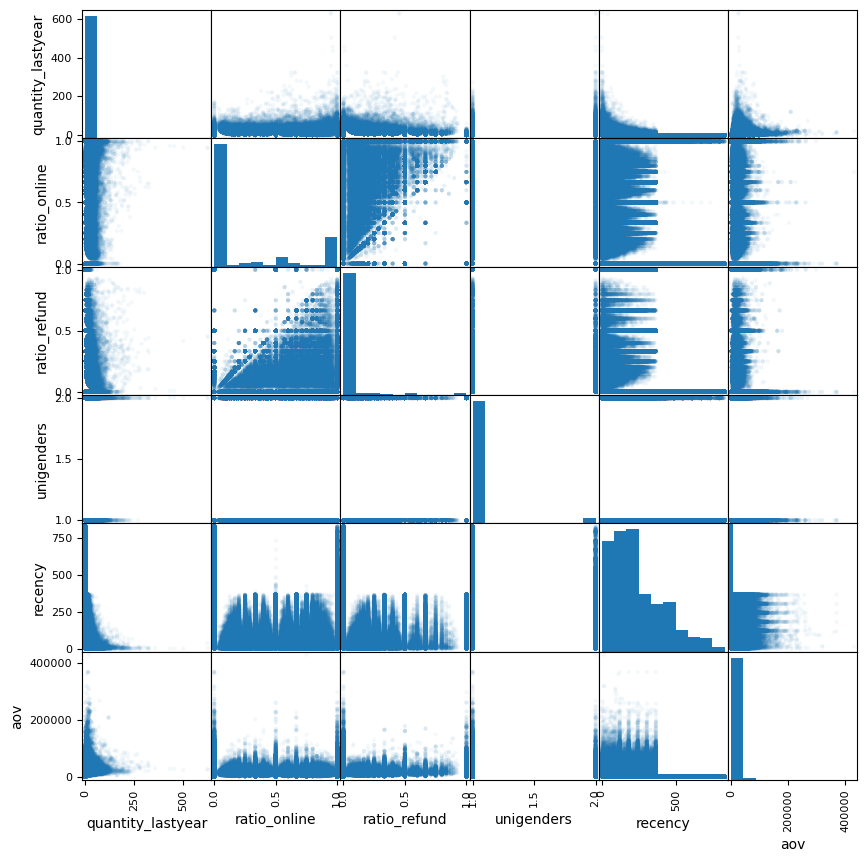

In [7]:
col = ['quantity_lastyear','ratio_online','ratio_refund','unigenders','recency', 'aov']
from pandas.plotting import scatter_matrix
scatter_matrix(df[col], alpha=0.05, figsize=(10,10));

In [8]:
#вычисляем коэффициенты корреляции кажддой из пар и анализируем их 
df[col].corr()

,quantity_lastyear,ratio_online,ratio_refund,unigenders,recency,aov
quantity_lastyear,1.000000,0.161590,0.090639,0.293624,-0.409678,0.331955
ratio_online,0.161590,1.000000,0.361032,0.082830,-0.253694,0.133119
ratio_refund,0.090639,0.361032,1.000000,0.024560,-0.103570,0.103948
unigenders,0.293624,0.082830,0.024560,1.000000,-0.136698,0.100513
recency,-0.409678,-0.253694,-0.103570,-0.136698,1.000000,-0.424026
aov,0.331955,0.133119,0.103948,0.100513,-0.424026,1.000000


Видим что выделяются следующие пары с высокими коэффициентами корреляции (брать будем те что больше 0.3 или меньше -0.3)
quantity_lastyear-aov: 0.331955
quantity_lastyear-recency: -0.409678
ratio_online-ratio_refund: 0.361032
recency-aov: -0.424026

Таким образом для кластеризации будем брать следующие параметры: quantity_lastyear, ratio_online, ratio_refund, recency, aov.

# K-means кластеризация

In [9]:
df1 = df[["quantity_lastyear","recency"]]

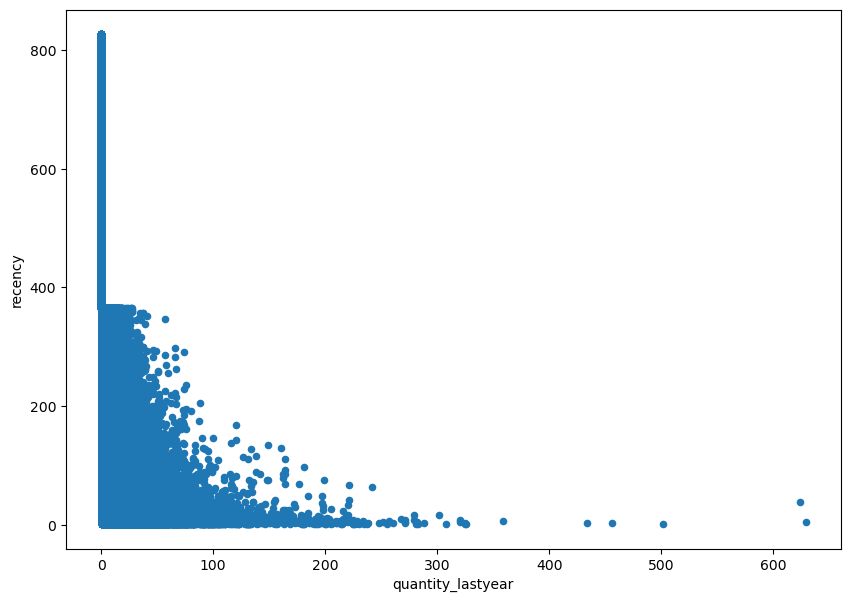

In [10]:
df1.plot(kind="scatter",
        x="quantity_lastyear",
        y="recency",
        figsize=(10, 7))
plt.show()

In [11]:
sum_of_sqr_dist = {}

for k in range(1, 10):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km = km.fit(df1)
    sum_of_sqr_dist[k] = km.inertia_

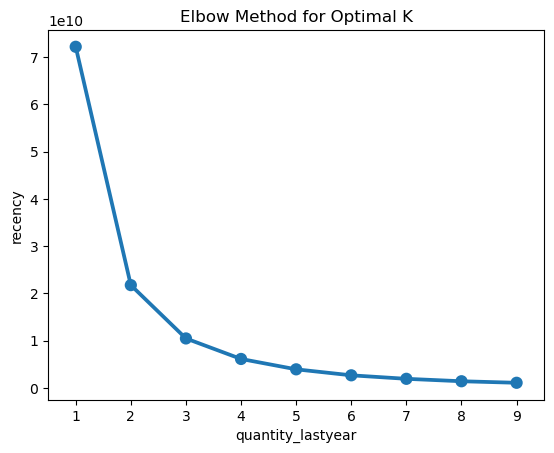

In [12]:
sns.pointplot(x=list(sum_of_sqr_dist.keys()), y=list(sum_of_sqr_dist.values()))
plt.xlabel("quantity_lastyear")
plt.ylabel("recency")
plt.title("Elbow Method for Optimal K")
plt.show()

In [ ]:
#Методом локтя определили оптимальное количество кластеров, видим что начиная с 4 график перестает стремительно падать

In [13]:
Model = KMeans(n_clusters=4,
             init='k-means++',
             max_iter=1000)
Model.fit(df1)

KMeans(max_iter=1000, n_clusters=4)

In [14]:
print("Labels", Model.labels_)

Labels [0 3 3 ... 0 3 3]


In [15]:
print("Centroids", Model.cluster_centers_)

Centroids [[ 6.10296126e+00  7.80925596e+01]
 [ 6.71012679e-01  4.10583733e+02]
 [-1.05648823e-12  6.26906096e+02]
 [ 2.37387355e+00  2.31272405e+02]]


In [16]:
centroids = Model.cluster_centers_

In [17]:
df1_cluster = df1.copy()
df1_cluster["Cluster"] = Model.fit_predict(df1)

In [18]:
df1_cluster.head()

,quantity_lastyear,recency,Cluster
0,4,123,2
1,4,182,0
2,4,243,0
3,4,304,0
4,4,365,3


визуализируем кластеры

In [20]:
Color = ['red', 'blue', 'black', 'yellow']
df1_cluster['Color'] = df1_cluster['Cluster'].map(lambda p:Color[p])

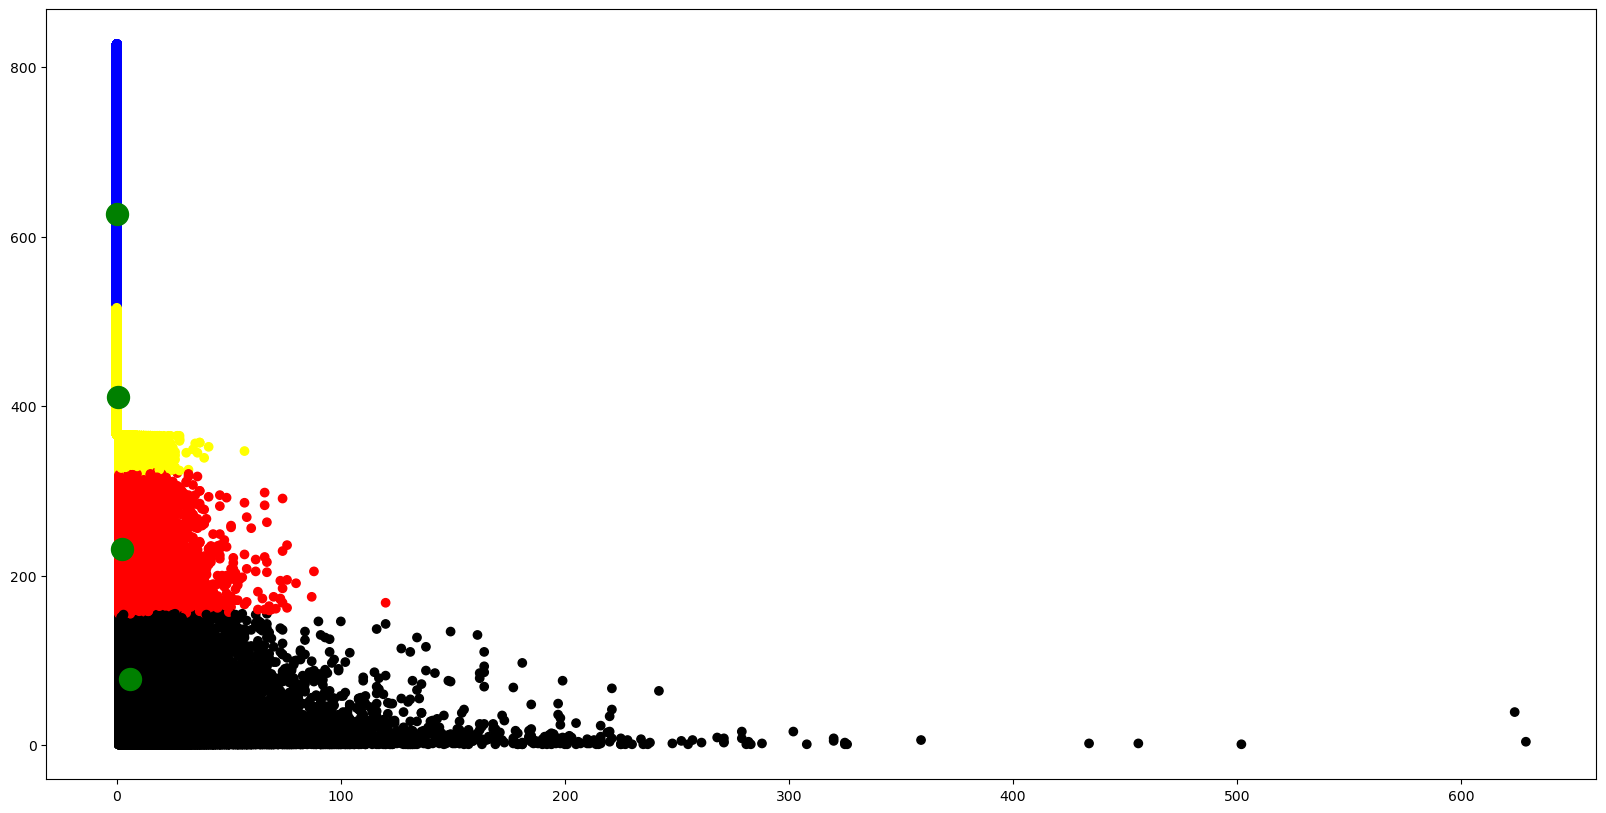

In [21]:
plt.figure(figsize=(20, 10))
plt.scatter(df1["quantity_lastyear"],
           df1["recency"],
           c=df1_cluster["Color"])

plt.scatter(centroids[:, 0], centroids[:, 1], c='green', s=250)
plt.show()

По графику соотношения количества дней от даты последнего выкупленного заказа до даты окончания i-ого периода и количества выкупленных единиц товаров за 1 год от даты окончания i-ого периода видим закономерность что чем больше дней от даты последнего выкупленного заказа тем меньше было сделано заказов и можем выделить четыре кластера (обозначены синим, желтым, красным и черными цветами):
Здесь к топовым клиентам можно отнести тех которые делали покупки  меньше чем за 150 дней до даты окончания i-ого периода.
Клиенты которые делали покупки больше чем за 350 дней до даты окончания i-ого периода находятся в предоттоке, оттоке, так как они с ростом количества дней стремительно умеьшаются и в конце совсем пропадают.